In [1]:
# 添加搜索路径
import sys
sys.path.insert(0, "/root/mounted/projects/qpair/")

In [2]:
import os
import pickle
import numpy as np
import time, datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from config import * # 加载全局配置
from baselines import MODEL_WEM # 加载模型
from baselines import MODEL_WEM_ATTENTION

MODEL_WEIGHTS_FILE = './keras_saved_models/baseline_model_wem.h5'

KN_PAIRS_SAMPLED_PATH = '/root/mounted/datasets/data_0521/intermediate/'
KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_pairs_sampled_wids_cids_train.pkl')
KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL = os.path.join(KN_PAIRS_SAMPLED_PATH, 'kn_pairs_sampled_wids_cids_test.pkl')

VALIDATION_SPLIT = 0.01
RNG_SEED = 13371447
NB_EPOCHS = 100
BATCH_SIZE = 1024

In [4]:
# 加载模型
model = MODEL_WEM()
# model = MODEL_WEM_ATTENTION()

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 39)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 39, 300)      6267600     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 39, 300)      6267600     input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

In [6]:
# 加载数据集，并切分成train 和 validation
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TRAIN_PKL, 'rb') as f:
    kn_train_wids_cids_padded = pickle.load(f)

kn_train_wids_cids_padded.head()

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q497036,Q562048,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Q572006,Q562048,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,Q255826,Q562048,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,Q444476,Q562048,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,Q555988,Q562048,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
with open(KN_PAIRS_SAMPLED_WIDS_CIDS_TEST_PKL, 'rb') as f:
    kn_test_wids_cids_padded = pickle.load(f)

kn_test_wids_cids_padded

,label,qid1,qid2,q1_q2_intersect,words1,chars1,words2,chars2
0,1,Q463697,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Q405900,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,Q160551,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,Q138477,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,Q077693,Q426562,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,0,Q650363,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,0,Q148251,Q426562,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,1,Q463697,Q199547,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,1,Q064245,Q199547,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,0,Q215247,Q199547,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
q1_inputs = kn_train_wids_cids_padded['words1'].values
q2_inputs = kn_train_wids_cids_padded['words2'].values
inputs = np.stack((q1_inputs, q2_inputs), axis=1)
labels = kn_train_wids_cids_padded['label']
inputs_train, inputs_val, labels_train, labels_val = train_test_split(inputs, labels, test_size=VALIDATION_SPLIT, random_state=RNG_SEED)
q1_train = np.array(list(inputs_train[:,0]))
q2_train = np.array(list(inputs_train[:,1]))
q1_val = np.array(list(inputs_val[:,0]))
q2_val = np.array(list(inputs_val[:,1]))

In [9]:
inputs_train.shape, inputs_val.shape

((324487, 2), (3278, 2))

In [10]:
np.array(list(q1_train)).shape

(324487, 39)

In [11]:
q1_test_inputs = np.array(list(kn_test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(kn_test_wids_cids_padded['words2'].values))
labels_test = kn_test_wids_cids_padded['label']

In [12]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True),TensorBoard(log_dir='/root/mounted/tensorboard/log')]
history = model.fit([q1_train, q2_train],
                    labels_train,
                    epochs=NB_EPOCHS,
                    validation_data = ([q1_test_inputs, q2_test_inputs], labels_test),
#                     validation_data = ([q1_val, q2_val], labels_val),
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2018-05-22 02:37:45.705031
Train on 324487 samples, validate on 72235 samples
Epoch 1/100
 - 7s - loss: 0.3863 - acc: 0.8381 - val_loss: 0.2879 - val_acc: 0.9031
Epoch 2/100
 - 7s - loss: 0.2316 - acc: 0.9185 - val_loss: 0.2410 - val_acc: 0.9159
Epoch 3/100
 - 6s - loss: 0.1969 - acc: 0.9294 - val_loss: 0.2026 - val_acc: 0.9233
Epoch 4/100
 - 7s - loss: 0.1774 - acc: 0.9364 - val_loss: 0.1857 - val_acc: 0.9277
Epoch 5/100
 - 7s - loss: 0.1610 - acc: 0.9411 - val_loss: 0.1834 - val_acc: 0.9324
Epoch 6/100
 - 7s - loss: 0.1497 - acc: 0.9455 - val_loss: 0.1621 - val_acc: 0.9386
Epoch 7/100
 - 7s - loss: 0.1400 - acc: 0.9487 - val_loss: 0.1764 - val_acc: 0.9366
Epoch 8/100
 - 7s - loss: 0.1318 - acc: 0.9519 - val_loss: 0.1439 - val_acc: 0.9444
Epoch 9/100
 - 7s - loss: 0.1256 - acc: 0.9540 - val_loss: 0.1399 - val_acc: 0.9465
Epoch 10/100
 - 6s - loss: 0.1192 - acc: 0.9564 - val_loss: 0.1360 - val_acc: 0.9479
Epoch 11/100
 - 7s - loss: 0.1137 - acc: 0.9582 - val_loss: 

Epoch 97/100
 - 7s - loss: 0.0304 - acc: 0.9899 - val_loss: 0.1010 - val_acc: 0.9620
Epoch 98/100
 - 7s - loss: 0.0306 - acc: 0.9897 - val_loss: 0.1085 - val_acc: 0.9594
Epoch 99/100
 - 7s - loss: 0.0298 - acc: 0.9899 - val_loss: 0.0965 - val_acc: 0.9654
Epoch 100/100
 - 7s - loss: 0.0293 - acc: 0.9901 - val_loss: 0.0966 - val_acc: 0.9641
Training ended at 2018-05-22 02:49:11.251661
Minutes elapsed: 11.425774


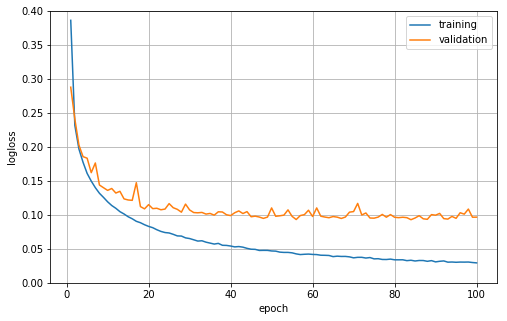

In [24]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in history.epoch ],
                    'training': history.history['loss'],
                    'validation': history.history['val_loss']})
ax = acc.iloc[:,:].plot(x='epoch', figsize=(8,5), grid=True)
ax.set_ylabel("logloss")
ax.set_ylim([0.0,0.4]);

In [14]:
history.history.keys()

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])

In [15]:
TEST_WIDS_CIDS_PADDED_PKL = os.path.join(INTERMEDIATE_DATA_PATH, 'test_clean_wids_cids_padded.pkl')
with open(TEST_WIDS_CIDS_PADDED_PKL, 'rb') as f:
    test_wids_cids_padded = pickle.load(f)
    
test_wids_cids_padded.head()

,q1,q2,qid1,qid2,label,words1,chars1,words2,chars2
0,021-31599453这个电话拍拍贷的电话号码吗?,我想知道人工台电话,Q345287,Q329078,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,021-31658089是贵公司电话吗?,打人工电话时多少,Q227821,Q460114,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,02131599589是你们的联系电话吗?,能告诉你们联系电话吗,Q449509,Q525440,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,02133328100是你们联系电话吗?,你们的联系电话是多说你们的联系电话是多少.,Q088371,Q364132,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0510 8051 2716请问这是贵公司电话么,02131658042电话号码是你公司的吗,Q163532,Q114092,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
q1_test_inputs = np.array(list(test_wids_cids_padded['words1'].values))
q2_test_inputs = np.array(list(test_wids_cids_padded['words2'].values))
test_labels = test_wids_cids_padded['label']
q1_test_inputs.shape

(24090, 39)

In [17]:
# 直接用最后一个epoch的模型
test_pred1 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred1 = test_pred1.squeeze()
test_pred1

array([0.11286494, 0.43814588, 0.70419496, ..., 0.02653425, 0.96764183,
       0.9607034 ], dtype=float32)

In [18]:
max(test_pred1), sum(test_pred1), sum(test_pred1) / 24090

(1.0, 17555.301924527656, 0.728738145476449)

In [19]:
test_pred1_df = pd.DataFrame({'y_pre':test_pred1})
test_pred1_df

,y_pre
0,0.112865
1,0.438146
2,0.704195
3,0.694042
4,0.979992
5,0.108784
6,0.022331
7,0.918425
8,0.976235
9,0.007040


In [20]:
TEST_PRED_1 = './predicts/test_pred1.csv'
test_pred1_df.to_csv(TEST_PRED_1, index=False)

In [21]:
model.load_weights(MODEL_WEIGHTS_FILE)
test_pred2 = model.predict([q1_test_inputs, q2_test_inputs], batch_size=BATCH_SIZE)
test_pred2 = test_pred2.squeeze()
test_pred2

array([0.06002822, 0.40917158, 0.23737088, ..., 0.01484715, 0.9254218 ,
       0.7483304 ], dtype=float32)

In [22]:
diff = test_pred2 - test_pred1
max(diff), sum(diff), sum(diff)/24090

(0.8393833, -1507.8341970148067, -0.0625917059781987)

In [23]:
score = model.evaluate([q1_test_inputs, q2_test_inputs], test_labels)
score

24090/24090 [==============================] - 4s 150us/step


[0.8040284821233991, 0.693565794915864]